In [1]:
import sqlite3
import pandas as pd
import matplotlib as rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# set style for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")

WIDTH = 5.8
SMALL_HEIGHT = 3
MEDIUM_HEIGHT = 5
BIGGER_HEIGHT = 7

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

OUTPUT = "../output/graph/"


In [2]:
# connect to database
connection = sqlite3.connect("../output/db/bulk_analysis_2019-11-08_1000ms.db")


In [3]:
# load games and moves into dataframes 
df_game_dirty = pd.read_sql("SELECT * FROM game", connection)
df_move_dirty = pd.read_sql("SELECT * FROM move", connection)

# remove games that are either too short or too long
df_game = remove_outlier(df_game_dirty, "length")
df_move = df_move_dirty.query("ply_number <= 133")
df_move.head()


,id,fullmove_number,ply_number,turn,san,lan,score,score_change,score_change_category,move_count,...,guarded_pieces_centipawn_all,attacked_guarded_pieces_centipawn_all,unopposed_threats_centipawn_all,threats_centipawn_all,attack_defense_relation1,attack_defense_relation2,material,pawn_ending,rook_ending,game_id
0,1,1,1,1,d4,d2-d4,-10,10,0.20,20,...,5800,0,0,0,0,-600,0,0,0,1
1,2,1,2,0,g6,g7-g6,118,128,2.56,20,...,5800,0,0,0,0,-500,0,0,0,1
2,3,2,3,1,c4,c2-c4,37,81,1.62,28,...,5700,0,0,0,0,-1500,0,0,0,1
3,4,2,4,0,Bg7,Bf8-g7,106,69,1.38,21,...,5900,100,0,0,600,-2100,0,0,0,1
4,5,3,5,1,Nf3,Ng1-f3,43,63,1.26,30,...,5900,100,0,0,900,-1300,0,0,0,1


Text(0, 0.5, 'capture')

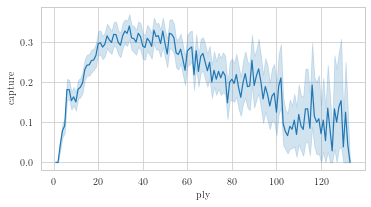

In [4]:
plt.figure(figsize=(WIDTH, SMALL_HEIGHT))
line_captures = sns.lineplot(x="ply_number", y="is_capture", data=df_move)#[df_move["game_id"].isin(df_game.query('length >= 100 & length <= 120')["id"])])
line_captures.set_xlabel("ply")
line_captures.set_ylabel("capture")

In [5]:
fig = line_captures.get_figure()
fig.tight_layout()
fig.savefig(OUTPUT+"line_captures.pdf")


In [6]:
df_move["is_capture"].head()




0    0
1    0
2    0
3    0
4    0
Name: is_capture, dtype: int64

Text(0, 0.5, 'is check')

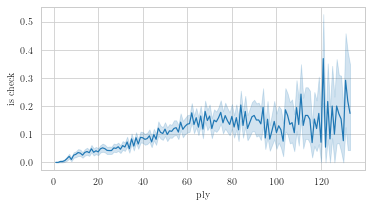

In [7]:
plt.figure(figsize=(WIDTH, SMALL_HEIGHT))
line_check = sns.lineplot(x="ply_number", y="is_check", data=df_move)
line_check.set_xlabel("ply")
line_check.set_ylabel("is check")

In [8]:
fig = line_check.get_figure()
fig.tight_layout()
fig.savefig(OUTPUT+"line_check.pdf")



In [9]:
df_move["is_check"].describe()

count    62009.000000
mean         0.075247
std          0.263792
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_check, dtype: float64

In [10]:
df_game_dirty = pd.read_sql("SELECT SUM(is_check) as is_check FROM move group by game_id", connection)
df_game_dirty.describe()


,is_check
count,989.000000
mean,4.794742
std,4.546357
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,52.000000


Text(0, 0.5, 'no. of legal moves')

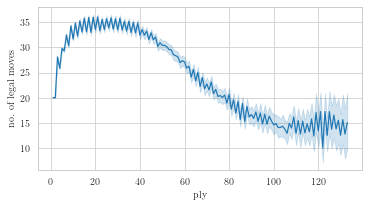

In [11]:
plt.figure(figsize=(WIDTH, SMALL_HEIGHT))
line_lmoves = sns.lineplot(x="ply_number", y="move_count", data=df_move)
line_lmoves.set_xlabel("ply")
line_lmoves.set_ylabel("no. of legal moves")


In [12]:
fig = line_lmoves.get_figure()
fig.tight_layout()
fig.savefig(OUTPUT+"line_lmoves.pdf")

Text(0, 0.5, '')

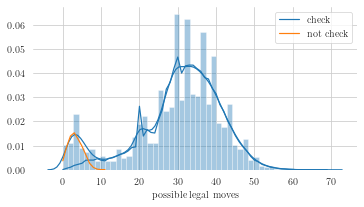

In [62]:

df_possible_moves = pd.read_sql("SELECT possible_moves_count, (count(*)*1.0/62009) as cnt, is_check as ischeck from move where ply_number <= 133 GROUP BY is_check, possible_moves_count ORDER BY is_check DESC, possible_moves_count ASC", connection)

f, ax = plt.subplots(figsize=(WIDTH, SMALL_HEIGHT), sharex=True, sharey=True)
sns.distplot(df_move["possible_moves_count"])
line_possible_moves = sns.lineplot(x="possible_moves_count", y="cnt", hue="ischeck", data=df_possible_moves)
sns.despine(left=True, bottom=True)
line_possible_moves.set_xlabel("possible legal moves")
ax.legend(labels=["check", "not check"], loc=0)
line_possible_moves.set_ylabel("")

In [55]:
fig = line_possible_moves.get_figure()
fig.tight_layout()
fig.savefig(OUTPUT+"line_possible_moves.pdf")


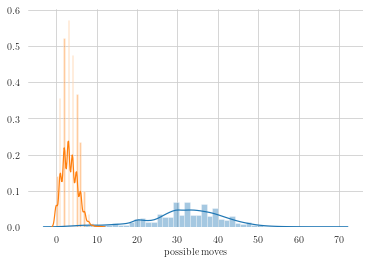

In [46]:
line_possible_moves = sns.distplot(df_move.query("is_check==0")["possible_moves_count"])
sns.distplot(df_move.query("is_check==1")["possible_moves_count"])
line_possible_moves.set_xlabel("possible moves")
sns.despine(left=True, bottom=True)

In [59]:
df_move.query("is_check==1")["possible_moves_count"].describe()

count    4666.000000
mean        3.329619
std         1.890862
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        11.000000
Name: possible_moves_count, dtype: float64

In [60]:
df_move.query("is_check==0")["possible_moves_count"].describe()

count    57343.000000
mean        31.792233
std          9.389842
min          0.000000
25%         27.000000
50%         33.000000
75%         38.000000
max         69.000000
Name: possible_moves_count, dtype: float64

In [61]:
df_move["possible_moves_count"].describe()

count    62009.000000
mean        29.650502
std         11.754858
min          0.000000
25%         24.000000
50%         32.000000
75%         38.000000
max         69.000000
Name: possible_moves_count, dtype: float64